# 1. Importing

In [ ]:
# Standard libraries
import logging
import os
import sys
import time
import re

# External libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import FastICA # decompose multivariate data into statistically independent components.
import matplotlib.pyplot as plt

# Project specific imports
from CONSTANTS import DEVICE, LOG_ROOT, PROJECT_ROOT, SESSION
from models.gru import AttGRUModel
from module.Common import batch_variable_inst, data_iter, generate_tinsts_binary_label
from module.Optimizer import Optimizer
from preprocessing.AutoLabeling import Probabilistic_Labeling
from preprocessing.datacutter.SimpleCutting import cut_by
from preprocessing.Preprocess import Preprocessor
from representations.sequences.statistics import Sequential_TF
from representations.templates.statistics import (
    Template_TF_IDF_without_clean,
)
from utils.Vocab import Vocab

2025-03-29 00:28:37,126 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct logger for Attention-Based GRU succeeded, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 00:28:37,292 - Preprocessor - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct logger for MTALog succeeded, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 00:28:37,294 - StatisticsRepresentation. - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct logger for Statistics Representation succeeded, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 00:28:37,296 - Statistics_Template_Encoder - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct logger for Statistics Template Encoder succeeded, current working directory: /Users/wind/Projects/AI/M

# 2. Custom default params

## 2.1. Hyper-params

In [2]:
# Define the word2vec file and its dimensions
word2vec_file = "glove.6B.300d.txt"
word2vec_dim = 300

# Set the hyperparameters
alpha = 8e-3    # Learning rate for meta-train
beta = 1        # Scaling factor for meta-test loss
gamma = 8e-3    # Learning rate

## 2.2. Network model params

In [3]:
# LSTM hidden units
lstm_hidden_units = 64

# Number of layers in the network
num_layers = 4

# Batch size for training
training_batch_size = 100

# Dropout rate
dropout_rate = 0.5

# Number of training epochs
num_epochs = 5

# Threshold for prediction
prediction_threshold = 0.5

## 2.3. Dataset params

In [4]:
# Define the parser type
parser = "IBM"

# Set the mode to 'train'
mode = "train"

# Parameters for clustering
min_cluster_size = 100
min_samples = 100

# Target dimension for reduction
reduce_dimensions = 50

# 3. Saving the model

In [ ]:
def get_file_paths(dataset, parser, min_cluster_size, min_samples, project_root):
    """
    Generate absolute paths for:
        - Probabilistic labeling results,
        - Random state cache (for reproducibility),
    based on dataset, parser, and clustering parameters.

    Args:
        dataset (str): Dataset name (e.g., "HDFS", "BGL").
        parser (str): Parser name (e.g., "IBM").
        min_cluster_size (int): Minimum cluster size for HDBSCAN.
        min_samples (int): Minimum number of core samples.
        project_root (str): Root directory of the project.

    Returns:
        tuple[str, str]:
            - prob_label_res_file: Path to probabilistic label results.
            - rand_state_file: Path to saved random state for reproducibility.
    """
    save_dir = os.path.join(project_root, "outputs")
    
    prob_label_res_file = os.path.join(
        save_dir,
        f"results/MTALog/{dataset}_{parser}/prob_label_res/mcs-{min_cluster_size}_ms-{min_samples}"
    )
    rand_state_file = os.path.join(
        save_dir,
        f"results/MTALog/{dataset}_{parser}/prob_label_res/random_state"
    )
    
    return prob_label_res_file, rand_state_file


# Generate file paths for HDFS (source dataset)
prob_label_res_file_HDFS, rand_state_file_HDFS = get_file_paths("HDFS", parser, min_cluster_size, min_samples, PROJECT_ROOT)

# Generate file paths for BGL (target dataset)
prob_label_res_file_BGL, rand_state_file_BGL = get_file_paths("BGL", parser, min_cluster_size, min_samples, PROJECT_ROOT)

# Shared model and result directories
output_model_dir = os.path.join(PROJECT_ROOT, f"outputs/models/MTALog/{parser}/model")
output_res_dir = os.path.join(PROJECT_ROOT, f"outputs/results/MTALog/{parser}/detect_res")

# 4. Function for updating model

In [ ]:
def get_updated_network(old, new, lr, load=False):
    """
    Perform a manual gradient-based parameter update on a model.

    This is used in the inner loop of MAML or similar meta-learning algorithms,
    where we simulate one (or more) gradient steps without modifying the original network in-place.

    Args:
        old (torch.nn.Module): The original model before adaptation.
        new (torch.nn.Module): A copy of the model to receive updated parameters.
        lr (float): Learning rate for the inner loop (usually meta-train step size).
        load (bool): If True, directly load updated weights using `load_state_dict`.
                     Otherwise, use `put_theta` to recursively assign updated weights.

    Returns:
        torch.nn.Module: A model with updated parameters after one gradient descent step.
    """
    updated_theta = {}
    state_dicts = old.state_dict()
    param_dicts = dict(old.named_parameters())

    for i, (k, v) in enumerate(state_dicts.items()):
        if k in param_dicts.keys() and param_dicts[k].grad is not None:
            updated_theta[k] = param_dicts[k] - lr * param_dicts[k].grad
        else:
            updated_theta[k] = state_dicts[k]
    if load:
        new.load_state_dict(updated_theta)
    else:
        new = put_theta(new, updated_theta)
    return new


def put_theta(model, theta):
    """
    Recursively set parameters of a PyTorch model using a custom dictionary of updated weights.

    Args:
        model (torch.nn.Module): Target model to modify.
        theta (dict): Dictionary mapping parameter names to updated tensors.

    Returns:
        torch.nn.Module: Model with parameters replaced by those in `theta`.
    """
    def k_param_fn(tmp_model, name=None):
        if len(tmp_model._modules) != 0:
            for k, v in tmp_model._modules.items():
                if name is None:
                    k_param_fn(v, name=str(k))
                else:
                    k_param_fn(v, name=str(name + "." + k))
        else:
            for k, v in tmp_model._parameters.items():
                if not isinstance(v, torch.Tensor):
                    continue
                tmp_model._parameters[k] = theta[str(name + "." + k)]

    k_param_fn(model)
    return model

# 5. Logging

## 5.1. Logging config

In [7]:
# Log setup
logger = logging.getLogger("MTALog")
logger.setLevel(logging.DEBUG)

# Formatter
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - " + SESSION + " - %(levelname)s: %(message)s"
)

# Console handler
console_handler = logging.StreamHandler(sys.stderr)
console_handler.setLevel(logging.DEBUG)
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# File handler
file_handler = logging.FileHandler(os.path.join(LOG_ROOT, "MTALog.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Successfully constructed
logger.info(
    f"Logger for MTALog constructed successfully. Current working directory: {os.getcwd()}. Logs will be written in {LOG_ROOT}."
)

2025-03-29 00:28:57,402 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Logger for MTALog constructed successfully. Current working directory: /Users/wind/Projects/AI/MTALog. Logs will be written in /Users/wind/Projects/AI/MTALog/logs.


## 5.2. Log custom params

In [8]:
# Log network parameters
logger.info("Network parameters:")
logger.info(f"  - LSTM hidden units: {lstm_hidden_units}")
logger.info(f"  - Number of layers: {num_layers}")
logger.info(f"  - Dropout rate: {dropout_rate}")

# Log hyperparameters
logger.info("Hyperparameters:")
logger.info(f"  - Alpha: {alpha}")
logger.info(f"  - Beta: {beta}")
logger.info(f"  - Gamma: {gamma}")
logger.info(f"  - Word2Vec file: {word2vec_file}")

2025-03-29 00:28:59,984 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Network parameters:
2025-03-29 00:28:59,986 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - LSTM hidden units: 64
2025-03-29 00:28:59,987 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Number of layers: 4
2025-03-29 00:28:59,987 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Dropout rate: 0.5
2025-03-29 00:28:59,988 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Hyperparameters:
2025-03-29 00:28:59,989 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Alpha: 0.008
2025-03-29 00:28:59,990 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Beta: 1
2025-03-29 00:28:59,991 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Gamma: 0.008
2025-03-29 00:28:59,992 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO:   - Word2Vec file: glove.6B.300d.txt


# 6. Import dataset

In [ ]:
def preprocess_data(dataset, parser, cut_func, template_encoder):
    """
    Load and parse log data, segment into train/dev/test sets, and encode templates.

    Args:
        dataset (str): Dataset name (e.g., "HDFS", "BGL").
        parser (str): Parsing method (e.g., "IBM" → Drain parser).
        cut_func (callable): Data split strategy function (e.g., cut_by, cut_all).
        template_encoder (object): Encoder with `.present()` method for template embedding.

    Returns:
        tuple: (train_data, valid_data, test_data, processor)
    """
    processor = Preprocessor()
    train_data, valid_data, test_data = processor.process(
        dataset=dataset,
        parsing=parser,
        cut_func=cut_func,
        template_encoding=template_encoder.present,
    )
    return train_data, valid_data, test_data, processor


def encode_log_sequences(processor, train_data, test_data=None):
    """
    Generate dense semantic representations for log sequences using a sequential encoder.

    Args:
        processor (Preprocessor): Contains template embeddings and id2embed.
        train_data (list[Instance]): Training data with event sequences.
        test_data (list[Instance], optional): Optional test data to encode.

    Returns:
        tuple: Updated train_data and optionally test_data, each with `.repr` assigned.
    """
    sequential_encoder = Sequential_TF(processor.embedding)
    
    train_reprs = sequential_encoder.present(train_data)
    for index, inst in enumerate(train_data):
        inst.repr = train_reprs[index]
    
    if (test_data is not None):
        test_reprs = sequential_encoder.present(test_data)
        for index, inst in enumerate(test_data):
            inst.repr = test_reprs[index]
            
        return train_data, test_data
    
    return train_data, None


def reduce_dimension(train_data, reduce_dimensions):
    """
    Apply FastICA to reduce the dimensionality of sequence representations.

    Args:
        train_data (list[Instance]): List of training instances with `.repr`.
        reduce_dimensions (int): Target dimension. If -1, skip reduction.

    Returns:
        list[Instance]: Updated training instances with reduced-dimensional vectors.
    """
    if reduce_dimensions != -1:
        start_time = time.time()
        print(f"Start FastICA, target dimension: {reduce_dimensions}.")
        transformer = FastICA(n_components=reduce_dimensions)
        train_reprs = np.array([inst.repr for inst in train_data])
        train_reprs_transform = transformer.fit_transform(train_reprs)
        for idx, inst in enumerate(train_data):
            inst.repr = train_reprs_transform[idx]
        print(f"Finished at {round(time.time() - start_time, 2)}.")
    return train_data


def probabilistic_labeling(train_data, min_samples, min_cluster_size, prob_label_res_file, rand_state_file):
    """
    Perform unsupervised probabilistic labeling using clustering on reduced vectors.

    Args:
        train_data (list[Instance]): Training set with `repr` vectors.
        min_samples (int): HDBSCAN minimum samples.
        min_cluster_size (int): HDBSCAN minimum cluster size.
        prob_label_res_file (str): Path to store/load clustering result.
        rand_state_file (str): Path to store/load random seed state.

    Returns:
        list[Instance]: Labeled training instances with `predicted` and `confidence`.
    """

    train_normal = [x for x, inst in enumerate(train_data) if inst.label == "Normal"]
    normal_ids = train_normal[: int(0.5 * len(train_normal))]
    
    label_generator = Probabilistic_Labeling(
        min_samples=min_samples,
        min_clust_size=min_cluster_size,
        res_file=prob_label_res_file,
        rand_state_file=rand_state_file,
    )
    labeled_train_data = label_generator.auto_label(train_data, normal_ids)
    return labeled_train_data

datasets = ["BGL", "HDFS"]
template_encoder = (
    Template_TF_IDF_without_clean(word2vec_file)
)

2025-03-29 00:29:17,099 - Statistics_Template_Encoder - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Loading word2vec dict from glove.6B.300d.txt.
2025-03-29 00:29:17,100 - Statistics_Template_Encoder - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Loading word2vec dict.
100%|██████████| 400000/400000 [00:22<00:00, 18054.47it/s]


## 6.1. Import BGL dataset

In [10]:
# Define the anomaly rate for BGL dataset
BGL_ANOMALY_RATE = 0.01  # 1% anomaly in BGL train dataset

# Preprocess BGL data with the specified anomaly rate in the train set
cut_func = cut_by(0.3, 0.0, BGL_ANOMALY_RATE)
train_BGL, _, test_BGL, processor_BGL = preprocess_data("BGL", parser, cut_func, template_encoder)

# Encode log sequences for the train and test sets
encoded_train_BGL, encoded_test_BGL = encode_log_sequences(processor_BGL, train_BGL, test_BGL)

# # Reduce dimensions of the encoded train set if necessary
# reduced_train_BGL = reduce_dimension(encoded_train_BGL, reduce_dimensions)

# # Perform probabilistic labeling on the reduced train set
# labeled_train_BGL = probabilistic_labeling(
#     reduced_train_BGL, min_samples, min_cluster_size, prob_label_res_file_BGL, rand_state_file_BGL
# )

# Assign the final train and test sets
final_train_BGL = encoded_train_BGL
final_test_BGL = encoded_test_BGL


2025-03-29 00:29:50,730 - BGLLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct self.logger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 00:29:50,732 - BGLLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Start load from previous extraction. File path /Users/wind/Projects/AI/MTALog/datasets/BGL/raw_log_seqs.txt
100%|██████████| 85577/85577 [00:01<00:00, 62592.11it/s] 
2025-03-29 00:29:52,291 - BGLLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Extraction finished successfully.
2025-03-29 00:29:52,292 - drain - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct DrainLogger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 00:29:52,293 - drain - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Load Drain configuration from /Users/wind/Projects/AI/MTALog/conf/BGL.ini

## 6.2. Import HDFS dataset

In [17]:
import pandas as pd

def convert_csv_to_label_txt(csv_path, output_path='label.txt'):
    # Đọc file CSV
    df = pd.read_csv(csv_path)
    
    # Chuyển label sang số: Normal = 0, Anomaly = 1
    df['Label'] = df['Label'].map({'Normal': 0, 'Anomaly': 1})
    
    # Ghi từng dòng theo định dạng "BlockId,label" vào file txt
    with open(output_path, 'w') as f:
        for _, row in df.iterrows():
            f.write(f"{row['BlockId']},{row['Label']}\n")

# Gọi hàm với đường dẫn đến file CSV
convert_csv_to_label_txt('datasets/HDFS/preprocessed/anomaly_label.csv')


In [18]:
# Define the anomaly rate for HDFS dataset
HDFS_ANOMALY_RATE = 1

# Preprocess HDFS data with the specified anomaly rate in the train set
cut_func = cut_by(1.0, 0.0, HDFS_ANOMALY_RATE)
train_HDFS, _, _, processor_HDFS = preprocess_data("HDFS", parser, cut_func, template_encoder)

# Encode log sequences for the train set
encoded_train_HDFS, _ = encode_log_sequences(processor_HDFS, train_HDFS)

# # Reduce dimensions of the encoded train set if necessary
# reduced_train_HDFS = reduce_dimension(encoded_train_HDFS, reduce_dimensions)

# # No probabilistic labeling for HDFS, use the reduced train set directly
# labeled_train_HDFS = reduced_train_HDFS

# Assign the final train set for HDFS
final_train_HDFS = encoded_train_HDFS

2025-03-29 01:15:30,454 - HDFSLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct self.logger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 01:15:30,454 - HDFSLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct self.logger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 01:15:30,454 - HDFSLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct self.logger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 01:15:30,454 - HDFSLoader - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Construct self.logger success, current working directory: /Users/wind/Projects/AI/MTALog, logs will be written in /Users/wind/Projects/AI/MTALog/logs
2025-03-29 01:15:30,454 - HDFSLoader - SESSION_9

## 6.3. Aggregate vocabulary

In [ ]:
def load_embeddings(processor):
    """
    Load event/template embeddings from a given Preprocessor and return a Vocab object.

    Args:
        processor (Preprocessor): Contains parsed templates and semantic representations.

    Returns:
        Vocab: A vocabulary object with internal word2id and embedding matrix initialized.
    """
    vocab = Vocab()
    vocab.load_from_dict(processor.embedding)
    return vocab

def merge_embeddings(processor_BGL, processor_HDFS):
    """
    Merge BGL and HDFS embeddings into a single dictionary, ensuring unique keys.

    Args:
        processor_BGL (Preprocessor): BGL log processor with .embedding.
        processor_HDFS (Preprocessor): HDFS log processor with .embedding.

    Returns:
        dict: Merged embedding dictionary with non-overlapping template indices.
    """
    new_embedding = processor_BGL.embedding.copy()
    padding_offset = len(processor_BGL.embedding)  # Use the length of BGL embedding as padding offset
    logger.info(f"Padding offset: {padding_offset}")
    for key, value in processor_HDFS.embedding.items():
        new_key = key + padding_offset  # Append padding offset to key to avoid conflicts
        new_embedding[new_key] = value
    
    return new_embedding

# Load embeddings for BGL and HDFS
vocab_BGL = load_embeddings(processor_BGL)
vocab_HDFS = load_embeddings(processor_HDFS)

# Merge embeddings from BGL and HDFS
merged_embedding = merge_embeddings(processor_BGL, processor_HDFS)

# Load merged embeddings into a new vocab object
vocab = Vocab()
vocab.load_from_dict(merged_embedding)

logger.info(f"All datasets: Total = {len(template_encoder.total_words_all)}, OOV = {len(template_encoder.num_oov_all)}")
logger.info(f"All datasets: OOV Rate = {(len(template_encoder.num_oov_all) / len(template_encoder.total_words_all))}")

2025-03-29 01:43:03,139 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Total words: 436
2025-03-29 01:43:03,141 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: The dim of pretrained embeddings: 300
2025-03-29 01:43:03,145 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Total words: 50
2025-03-29 01:43:03,147 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: The dim of pretrained embeddings: 300
2025-03-29 01:43:03,149 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Padding offset: 432
2025-03-29 01:43:03,150 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Total words: 482
2025-03-29 01:43:03,151 - Vocab - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: The dim of pretrained embeddings: 300
2025-03-29 01:43:03,154 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: All datasets: Total = 1323, OOV = 973
2025-03-29 01:43:03,155 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: All datasets: OOV Rate = 0.7

# 7. Training

## 7.1. MetaLog class

In [ ]:
class MTALog:
    """
    MTALog integrates an attention-based bidirectional GRU network for log sequence anomaly classification.

    It supports both supervised training and evaluation with a configurable architecture and dual-network design
    (main model and backup model). It is designed for few-shot adaptation and meta-learning settings.
    """
    def __init__(self, vocab, num_layer, hidden_size, drop_out, label2id):
        """
        Initialize the MTALog model with architecture and training configuration.

        Args:
            vocab (Vocab): Vocabulary object containing word embeddings and token mappings.
            num_layer (int): Number of GRU layers in the model.
            hidden_size (int): Hidden size of the GRU (per direction).
            drop_out (float): Dropout rate applied to input embeddings.
            label2id (dict): Mapping from label names ("Normal", "Anomalous") to class indices.
        """
        self.label2id = label2id
        self.vocab = vocab
        self.num_layer = num_layer
        self.hidden_size = hidden_size
        self.batch_size = 128
        self.test_batch_size = 1024
        self.drop_out = drop_out
        
        # Initialize the main and backup models
        self.model = AttGRUModel(vocab, num_layer, hidden_size, drop_out)
        self.bk_model = AttGRUModel(vocab, num_layer, hidden_size, drop_out, is_backup=True)
        
        # Move models to GPU if available
        if torch.cuda.is_available():
            self.model = self.model.cuda(DEVICE)
            self.bk_model = self.bk_model.cuda(DEVICE)
        elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
            self.model = self.model.to(DEVICE)
            self.bk_model = self.bk_model.to(DEVICE)
        
        # Define the loss function
        self.loss = nn.BCELoss()

    def forward(self, inputs, targets):
        """
        Forward pass through the main model and compute the classification loss.

        Args:
            inputs (tuple): A tuple containing input sequences, masks, and lengths.
            targets (Tensor): Ground-truth labels in one-hot format or probability distribution.

        Returns:
            Tensor: Scalar loss computed using binary cross-entropy.
        """
        tag_logits = self.model(inputs)
        tag_logits = F.softmax(tag_logits, dim=1)
        loss = self.loss(tag_logits, targets)
        return loss

    def bk_forward(self, inputs, targets):
        """
        Forward pass through the backup model and compute the classification loss.

        This method is typically used during meta-learning inner loop updates.

        Args:
            inputs (tuple): A tuple containing input sequences, masks, and lengths.
            targets (Tensor): Ground-truth labels in one-hot format or probability distribution.

        Returns:
            Tensor: Scalar loss computed using binary cross-entropy.
        """
        tag_logits = self.bk_model(inputs)
        tag_logits = F.softmax(tag_logits, dim=1)
        loss = self.loss(tag_logits, targets)
        return loss

    def predict(self, inputs, threshold=None):
        """
        Perform prediction on input sequences and return predicted tags and probabilities.

        Args:
            inputs (tuple): A tuple of (word indices, masks, lengths).
            threshold (float, optional): If specified, use a threshold on anomaly probability.
                                        Otherwise, use argmax over softmax output.

        Returns:
            tuple:
                - pred_tags (Tensor or ndarray): Predicted class labels (0 for Normal, 1 for Anomalous).
                - tag_logits (Tensor): Softmax probabilities over the two classes.
        """
        with torch.no_grad():
            tag_logits = self.model(inputs)
            tag_logits = F.softmax(tag_logits, dim=1)
        
        if threshold is not None:
            # Apply threshold to determine anomalous tags
            probs = tag_logits.detach().cpu().numpy()
            anomaly_id = self.label2id["Anomalous"]
            pred_tags = np.zeros(probs.shape[0])
            
            for i, logits in enumerate(probs):
                if logits[anomaly_id] >= threshold:
                    pred_tags[i] = anomaly_id
                else:
                    pred_tags[i] = 1 - anomaly_id
        else:
            # Use max value to determine tags
            pred_tags = tag_logits.detach().max(1)[1].cpu()
        
        return pred_tags, tag_logits

    def evaluate(self, dataset, instances, threshold=0.5):
        """
        Evaluate model performance on a given dataset.

        Iterates through the dataset in batches, performs prediction, and computes
        precision, recall, and F1-score based on predicted vs. true labels.

        Args:
            dataset (str): Dataset name for logging purposes (e.g., "BGL").
            instances (list): List of log instances to evaluate.
            threshold (float): Probability threshold for deciding anomaly class.

        Returns:
            tuple:
                - precision (float): Precision in percentage.
                - recall (float): Recall in percentage.
                - f1_score (float): F1-score in percentage.
        """
        logger.info(f"Start evaluating {dataset} by threshold {threshold}")
        
        with torch.no_grad():
            self.model.eval()
            globalBatchNum = 0
            TP, TN, FP, FN = 0, 0, 0, 0
            tag_correct, tag_total = 0, 0
            
            for onebatch in data_iter(instances, self.test_batch_size, False):
                tinst = generate_tinsts_binary_label(onebatch, vocab_BGL, False)
                
                if torch.cuda.is_available():
                    tinst.to_cuda(DEVICE)
                elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                    tinst.to_mps(DEVICE)
                
                pred_tags, tag_logits = self.predict(tinst.inputs, threshold)
                
                for inst, bmatch in batch_variable_inst(onebatch, pred_tags, tag_logits, processor_BGL.id2tag):
                    tag_total += 1
                    if bmatch:
                        tag_correct += 1
                        if inst.label == "Normal":
                            TN += 1
                        else:
                            TP += 1
                    else:
                        if inst.label == "Normal":
                            FP += 1
                        else:
                            FN += 1
                
                globalBatchNum += 1
            
            if TP + FP != 0:
                # Calculate precision, recall, and F1 score
                precision = 100 * TP / (TP + FP)
                recall = 100 * TP / (TP + FN)
                f1_score = 2 * precision * recall / (precision + recall)
                logger.info(f"{dataset}: F1 score = {f1_score} | Precision = {precision} | Recall = {recall}")
            else:
                logger.info(f"{dataset}: F1 score = {0} | Precision = {0} | Recall = {0}")
                precision, recall, f1_score = 0, 0, 0
        
        return precision, recall, f1_score

# Instantiate the MTALog class with given parameters
metalog = MTALog(
    vocab=vocab,
    num_layer=num_layers,
    hidden_size=lstm_hidden_units,
    drop_out=dropout_rate,
    label2id=processor_BGL.label2id,
)

2025-03-29 01:43:06,267 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: ==== Model Parameters ====
2025-03-29 01:43:06,268 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Input Dimension: 300
2025-03-29 01:43:06,269 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Hidden Size: 64
2025-03-29 01:43:06,269 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Num Layers: 4
2025-03-29 01:43:06,270 - AttGRU - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Dropout: 0.5


2 128
Orthogonal pretrainer loss: 4.76e-02
2 128
Orthogonal pretrainer loss: 1.65e+06


## 7.2. Model saving

In [21]:
"""Create the model output directory if it doesn't exist."""
if not os.path.exists(output_model_dir):
    os.makedirs(output_model_dir)

"""Construct and return the paths for the best and last model files."""
info = f"layer={num_layers}_hidden={lstm_hidden_units}_dropout_{dropout_rate}_epoch={num_epochs}"

best_model_file = os.path.join(output_model_dir, info + "_best.pt")
last_model_file = os.path.join(output_model_dir, info + "_last.pt")

## 7.3. Training

In [22]:
if mode == "train":
    # Initialize optimizer
    optimizer = Optimizer(
        filter(lambda p: p.requires_grad, metalog.model.parameters()), lr=gamma
    )
    global_step = 0
    best_f1_score = 0

    for epoch in range(1, num_epochs + 1):
        metalog.model.train()
        metalog.bk_model.train()
        start_time = time.strftime("%H:%M:%S")
        
        logger.info(
            f"Starting epoch: {epoch} | Phase: Train | Start time: {start_time} | Alpha: {alpha} | Beta = {beta} | Gamma = {gamma}."
        )

        batch_num_train = int(np.ceil(len(final_train_HDFS) / float(training_batch_size)))
        batch_num_test = int(np.ceil(len(final_train_BGL) / float(training_batch_size)))
        total_batches = max(batch_num_train, batch_num_test)
        print(f"Batch train: {batch_num_train}; Length train: {len(final_train_HDFS)}")
        print(f"Batch test: {batch_num_test}; Length train: {len(final_train_BGL)}")

        meta_train_loader = data_iter(final_train_HDFS, training_batch_size, True)
        meta_test_loader = data_iter(final_train_BGL, training_batch_size, True)

        
        for _ in range(total_batches):
            optimizer.zero_grad()

            # Meta-train on HDFS
            try:
                meta_train_batch = next(meta_train_loader)
            except StopIteration:
                meta_train_batch = data_iter(final_train_BGL, training_batch_size, True)
                meta_train_batch = next(meta_train_loader)
                
            tinst_train = generate_tinsts_binary_label(meta_train_batch, vocab)
            if torch.cuda.is_available():
                tinst_train.to_cuda(DEVICE)
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                tinst_train.to_mps(DEVICE)
            train_loss = metalog.forward(tinst_train.inputs, tinst_train.targets)
            train_loss_value = train_loss.data.cpu().numpy()
            train_loss.backward(retain_graph=True)
            
            # Update backup model
            if torch.cuda.is_available():
                metalog.bk_model = (
                    get_updated_network(metalog.model, metalog.bk_model, alpha)
                    .train()
                    .cuda()
                )
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                metalog.bk_model = (
                    get_updated_network(metalog.model, metalog.bk_model, alpha)
                    .train()
                    .to(DEVICE)
                )
            else:
                metalog.bk_model = get_updated_network(
                    metalog.model, metalog.bk_model, alpha
                ).train()

            # Meta-test on BGL
            try:
                meta_test_batch = next(meta_test_loader)
            except StopIteration:
                meta_test_loader = data_iter(final_train_BGL, training_batch_size, True)
                meta_test_batch = next(meta_test_loader)
                
            tinst_test = generate_tinsts_binary_label(meta_test_batch, vocab_BGL)
            if torch.cuda.is_available():
                tinst_test.to_cuda(DEVICE)
            elif hasattr(torch.mps, "is_available") and torch.mps.is_available():
                tinst_test.to_mps(DEVICE)
            test_loss = beta * metalog.bk_forward(tinst_test.inputs, tinst_test.targets)
            test_loss_value = test_loss.data.cpu().numpy() / beta
            test_loss.backward()

            # Update the model
            optimizer.step()
            global_step += 1

            if global_step % 10 == 0:
                logger.info(
                    f"Step: {global_step} | Epoch: {epoch} | Meta-train loss: {train_loss_value} | Meta-test loss: {test_loss_value}."
                )

        # Evaluate and save the model
        if final_test_BGL:
            _, _, f1_score = metalog.evaluate("Test", final_test_BGL)
            if f1_score > best_f1_score:
                logger.info(
                    f"Exceed best F1 score: history = {best_f1_score}, current = {f1_score}."
                )
                torch.save(metalog.model.state_dict(), best_model_file)
                best_f1_score = f1_score

        logger.info(f"Training epoch {epoch} finished.")
        torch.save(metalog.model.state_dict(), last_model_file)


2025-03-29 01:43:16,814 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Starting epoch: 1 | Phase: Train | Start time: 01:43:16 | Alpha: 0.008 | Beta = 1 | Gamma = 0.008.


Batch train: 5751; Length train: 575061
Batch test: 165; Length train: 16462


2025-03-29 01:43:30,342 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 10 | Epoch: 1 | Meta-train loss: 0.11335241049528122 | Meta-test loss: 0.061448995023965836.
2025-03-29 01:43:42,308 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 20 | Epoch: 1 | Meta-train loss: 0.08307855576276779 | Meta-test loss: 0.062031932175159454.
2025-03-29 01:43:55,593 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 30 | Epoch: 1 | Meta-train loss: 0.2631213366985321 | Meta-test loss: 0.0570453442633152.
2025-03-29 01:44:12,691 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 40 | Epoch: 1 | Meta-train loss: 0.002623320324346423 | Meta-test loss: 0.0012483089230954647.
2025-03-29 01:44:30,218 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 50 | Epoch: 1 | Meta-train loss: 0.18170477449893951 | Meta-test loss: 0.014075584709644318.
2025-03-29 01:44:47,236 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: St

Batch train: 5751; Length train: 575061
Batch test: 165; Length train: 16462


2025-03-29 04:15:18,134 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 5760 | Epoch: 2 | Meta-train loss: 0.011690809391438961 | Meta-test loss: 0.0008228945080190897.
2025-03-29 04:15:32,520 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 5770 | Epoch: 2 | Meta-train loss: 0.0059815263375639915 | Meta-test loss: 0.0009892170783132315.
2025-03-29 04:15:46,074 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 5780 | Epoch: 2 | Meta-train loss: 0.059100281447172165 | Meta-test loss: 0.0007576225907541811.
2025-03-29 04:16:00,120 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 5790 | Epoch: 2 | Meta-train loss: 0.05682472139596939 | Meta-test loss: 0.005033525172621012.
2025-03-29 04:16:14,229 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 5800 | Epoch: 2 | Meta-train loss: 0.057175055146217346 | Meta-test loss: 0.0019522638758644462.
2025-03-29 04:16:28,493 - MTALog - SESSION_93498902e4224ed7346c439

Batch train: 5751; Length train: 575061
Batch test: 165; Length train: 16462


2025-03-29 06:32:32,942 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 11510 | Epoch: 3 | Meta-train loss: 0.060196276754140854 | Meta-test loss: 0.00048762522055767477.
2025-03-29 06:32:46,240 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 11520 | Epoch: 3 | Meta-train loss: 0.006906895432621241 | Meta-test loss: 0.0006569594843313098.
2025-03-29 06:32:59,853 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 11530 | Epoch: 3 | Meta-train loss: 0.10582541674375534 | Meta-test loss: 0.0014953798381611705.
2025-03-29 06:33:13,423 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 11540 | Epoch: 3 | Meta-train loss: 0.06552180647850037 | Meta-test loss: 0.0007465934031642973.
2025-03-29 06:33:27,291 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 11550 | Epoch: 3 | Meta-train loss: 0.01029870007187128 | Meta-test loss: 0.0011082979617640376.
2025-03-29 06:33:41,116 - MTALog - SESSION_93498902e4224ed7346

Batch train: 5751; Length train: 575061
Batch test: 165; Length train: 16462


2025-03-29 08:47:51,928 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 17260 | Epoch: 4 | Meta-train loss: 0.0048465486615896225 | Meta-test loss: 0.0008745544473640621.
2025-03-29 08:48:05,944 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 17270 | Epoch: 4 | Meta-train loss: 0.05265561118721962 | Meta-test loss: 0.0008463289123028517.
2025-03-29 08:48:19,360 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 17280 | Epoch: 4 | Meta-train loss: 0.005243478808552027 | Meta-test loss: 0.0013060938799753785.
2025-03-29 08:48:33,467 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 17290 | Epoch: 4 | Meta-train loss: 0.0060997833497822285 | Meta-test loss: 0.001034403103403747.
2025-03-29 08:48:47,294 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 17300 | Epoch: 4 | Meta-train loss: 0.004697030410170555 | Meta-test loss: 0.0008725302177481353.
2025-03-29 08:49:01,335 - MTALog - SESSION_93498902e4224ed73

Batch train: 5751; Length train: 575061
Batch test: 165; Length train: 16462


2025-03-29 11:07:04,213 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 23010 | Epoch: 5 | Meta-train loss: 0.03755433112382889 | Meta-test loss: 0.0008617298444733024.
2025-03-29 11:07:17,849 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 23020 | Epoch: 5 | Meta-train loss: 0.006671094801276922 | Meta-test loss: 0.0008634885307401419.
2025-03-29 11:07:31,813 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 23030 | Epoch: 5 | Meta-train loss: 0.005600415635854006 | Meta-test loss: 0.0008264105999842286.
2025-03-29 11:07:45,523 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 23040 | Epoch: 5 | Meta-train loss: 0.04334293305873871 | Meta-test loss: 0.0009127278462983668.
2025-03-29 11:08:01,033 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Step: 23050 | Epoch: 5 | Meta-train loss: 0.10444658994674683 | Meta-test loss: 0.001072313287295401.
2025-03-29 11:08:15,003 - MTALog - SESSION_93498902e4224ed7346c4

# 8. Evaluate

In [23]:
# Check if the last model file exists and evaluate it
if os.path.exists(last_model_file):
    logger.info("=== Evaluating Final Model ===")
    metalog.model.load_state_dict(torch.load(last_model_file))
    metalog.evaluate("Final Model on Test BGL", final_test_BGL)

# Check if the best model file exists and evaluate it
if os.path.exists(best_model_file):
    logger.info("=== Evaluating Best Model ===")
    metalog.model.load_state_dict(torch.load(best_model_file))
    metalog.evaluate("Best Model on Test BGL", final_test_BGL)

logger.info("All evaluations finished!")

2025-03-29 13:29:51,187 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: === Evaluating Final Model ===
2025-03-29 13:29:51,209 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Start evaluating Final Model on Test BGL by threshold 0.5
2025-03-29 13:32:14,274 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Final Model on Test BGL: F1 score = 79.08129754009789 | Precision = 92.31758595102646 | Recall = 69.16462827069898
2025-03-29 13:32:14,277 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: === Evaluating Best Model ===
2025-03-29 13:32:14,287 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Start evaluating Best Model on Test BGL by threshold 0.5
2025-03-29 13:34:42,454 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: Best Model on Test BGL: F1 score = 85.75085820678419 | Precision = 89.94263395581594 | Recall = 81.93239937736269
2025-03-29 13:34:42,456 - MTALog - SESSION_93498902e4224ed7346c4397a2b38432 - INFO: All eva

# 9. Export to graph

## 9.1. Constanst

In [24]:
STATISTICS_TEMPLATE_LOG_PATH = "logs/Statistics_Template.log"
MTALOG_LOG_PATH = "logs/MTALog.log"

## 9.2. Extracting

In [28]:
def extract_word2vec_file(log_path, session):
    """Extract the word2vec file path from the statistics template log."""
    with open(log_path, "r") as file:
        for line in file:
            match = re.search(rf"^.+ - Statistics_Template_Encoder - {session} - INFO: Loading word2vec dict from (.+)\.$", line)
            if match:
                return match.group(1)

def extract_f1_scores(log_path, session):
    """Extract train and test F1 scores from the MTALog."""
    train_f1_scores, test_f1_scores = [], []
    with open(log_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            train_match = re.search(rf"^.+ - MTALog - {session} - INFO: Train: F1 score = (.+) \| Precision = (.+) \| Recall = (.+)$", line)
            test_match = re.search(rf"^.+ - MTALog - {session} - INFO: Test: F1 score = (.+) \| Precision = (.+) \| Recall = (.+)$", line)

            if train_match:
                train_f1_scores.append(float(train_match.group(1)))
            if test_match:
                test_f1_scores.append(float(test_match.group(1)))
    return train_f1_scores, test_f1_scores

def extract_meta_losses(log_path, session):
    """Extract meta-train and meta-test losses from the MTALog."""
    meta_train_losses, meta_test_losses = [], []
    with open(log_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            match = re.search(rf"^.* - MTALog - {session} - INFO: Step: (.+) \| Epoch: (.+) \| Meta-train loss: (.+) \| Meta-test loss: (.+)\.$", line)
            if match:
                meta_train_losses.append(float(match.group(3)))
                meta_test_losses.append(float(match.group(4)))

    return meta_train_losses, meta_test_losses

# Extract the word2vec file path
word2vec_file = extract_word2vec_file(STATISTICS_TEMPLATE_LOG_PATH, SESSION)
title = f"BILATERAL GENERALIZATION TRANSFERRING HDFS TO BGL USING {word2vec_file}"

# Extract F1 scores and losses
train_f1_scores, test_f1_scores = extract_f1_scores(MTALOG_LOG_PATH, SESSION)
meta_train_losses, meta_test_losses = extract_meta_losses(MTALOG_LOG_PATH, SESSION)

print(train_f1_scores, test_f1_scores)
print(meta_train_losses, meta_test_losses)

[] [85.75085820678419, 76.50700136612022, 79.31122017261804, 79.1533495608001, 79.08129754009789]
[0.11335241049528122, 0.08307855576276779, 0.2631213366985321, 0.002623320324346423, 0.18170477449893951, 0.07222418487071991, 0.24028408527374268, 0.16433152556419373, 0.07512841373682022, 0.10506687313318253, 0.11172714084386826, 0.0868188738822937, 0.09678009152412415, 0.07499758154153824, 0.07603722810745239, 0.031852755695581436, 0.08235011249780655, 0.06020784378051758, 0.26861312985420227, 0.1270582675933838, 0.013159582391381264, 0.010535115376114845, 0.0008813285967335105, 0.061552561819553375, 0.003580325748771429, 0.033449482172727585, 0.016726046800613403, 0.05445406958460808, 0.06596068292856216, 0.06828291714191437, 0.002098051132634282, 0.055715952068567276, 0.10741052031517029, 0.013604925945401192, 0.058466337621212006, 0.005828543100506067, 0.0025643077678978443, 0.10424188524484634, 0.027575775980949402, 0.0039040884003043175, 0.10958423465490341, 0.10742562264204025, 0.

## 9.3. Plotting

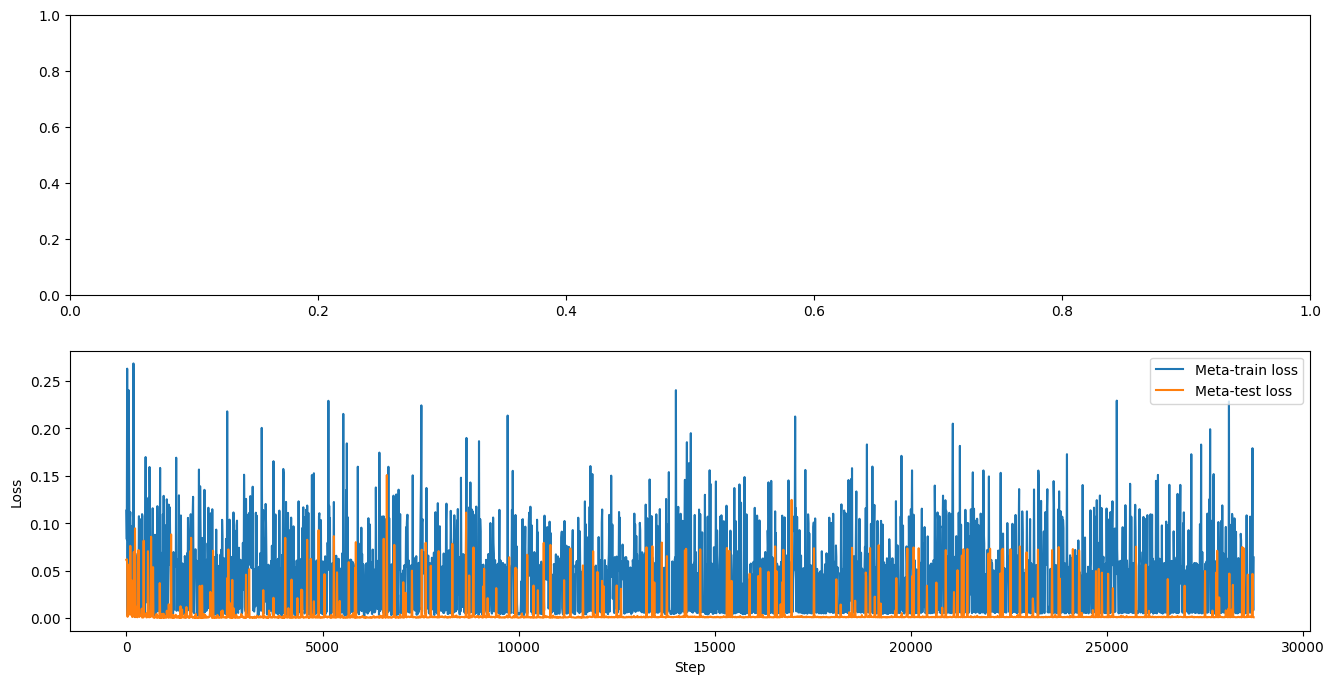

In [29]:
def plot_f1_scores(ax, num_epochs, train_f1, test_f1):
    """Plot train and test F1 scores on the provided axis."""
    ax.set_ylim(0, 110)
    ax.plot(num_epochs, train_f1, color="tab:blue")
    ax.plot(num_epochs, test_f1, color="tab:orange")
    ax.legend(["Train", "Test"])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1 Score")

    for i in range(len(num_epochs)):
        ax.plot(num_epochs[i], train_f1[i], "o", color="tab:blue", zorder=10)
        ax.text(num_epochs[i], train_f1[i] + 5, round(train_f1[i], 2), ha="center")

        ax.plot(num_epochs[i], test_f1[i], "o", color="tab:orange", zorder=10)
        ax.text(num_epochs[i], test_f1[i] - 10, round(test_f1[i], 2), ha="center")

def plot_meta_losses(ax, num_steps, meta_train_losses, meta_test_losses):
    """Plot meta-train and meta-test losses on the provided axis."""
    ax.plot(num_steps, meta_train_losses, color="tab:blue")
    ax.plot(num_steps, meta_test_losses, color="tab:orange")
    ax.legend(["Meta-train loss", "Meta-test loss"])
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    
# Plot F1 scores and losses
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
num_epochs = list(range(len(train_f1_scores)))
num_steps = [i * 10 for i in range(len(meta_train_losses))]

#plot_f1_scores(axs[0], num_epochs, train_f1_scores, test_f1_scores)
plot_meta_losses(axs[1], num_steps, meta_train_losses, meta_test_losses)

## 9.4. Saving and exporting

In [ ]:
# Set the title for the plot
best_test_f1_score = max(test_f1_scores)
fig_title = f"{title}\nBest model F1 Score = {best_test_f1_score}\nLSTM hidden units = {lstm_hidden_units} | Layers = {num_layers} | Drop out = {dropout_rate} | Alpha = {alpha} | Beta = {beta} | Gamma = {gamma}"
fig.suptitle(fig_title)

# Define the path to save the plot
plot_dir = os.path.join("visualization", "graphs")
plot_filename = f"{alpha}-{beta}-{gamma}-{word2vec_file}-{SESSION}.png"
plot_path = os.path.join(plot_dir, plot_filename)

# Ensure the directory exists
os.makedirs(plot_dir, exist_ok=True)

# Save the plot
fig.savefig(plot_path)